# Mall Customer Segmentation -
# Unsupervised Algorithms in Machine Learning Final Project

# Description

For this project, I'll be using the Mall Customer Segmentation dataset from Kaggle.

**Problem:** A company in the mall wants to identify target customers (customers with a high spending score). Below I will perform Customer Segmentation and Cluster Analysis with unsupervised learning and clustering techniques.

The dataset can be found on Kaggle at this link: [Mall Customer Segmentation](https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python/data)



In [1]:
from google.colab import userdata
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [2]:
!pip install -q kaggle;

In [3]:
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [4]:
!kaggle datasets download vjchoudhary7/customer-segmentation-tutorial-in-python

Dataset URL: https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python
License(s): other
  0% 0.00/1.55k [00:00<?, ?B/s]
100% 1.55k/1.55k [00:00<00:00, 2.03MB/s]


In [5]:
%%capture
!unzip "customer-segmentation-tutorial-in-python.zip"

# Exploratory Data Analysis

First let's explore the dataset and see what we can find out about it...

In [6]:
df = pd.read_csv('Mall_Customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [8]:
df.isnull().sum()

,0
CustomerID,0
Gender,0
Age,0
Annual Income (k$),0
Spending Score (1-100),0


In [9]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [10]:
df['Gender'].unique()

array(['Male', 'Female'], dtype=object)

**Initial Observations:** We observe that the dataset does not have any null values, and there are only 200 rows in the dataset. We also have 4 int columns and one Gender column where the values can be Male or Female. This is a pretty small amount of data, but I believe that also makes it practical since we are assiting a supermarket mall and the data we have is supposedly collected through memberships.

let's look at the distributions of each column to see if there are any insights into the observed population.

In [11]:
def plot_hist(col):
    plt.figure(figsize=(4, 4))
    plt.hist(df[col], bins=20, edgecolor='black', alpha=0.7)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.title(f"Distribution of {col}")
    plt.show()

In [12]:
df['Gender'].value_counts()

,count
Gender,
Female,112
Male,88


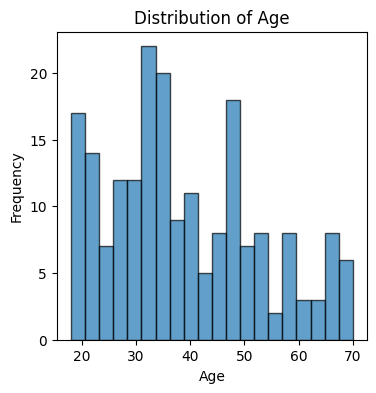

In [13]:
plot_hist("Age")

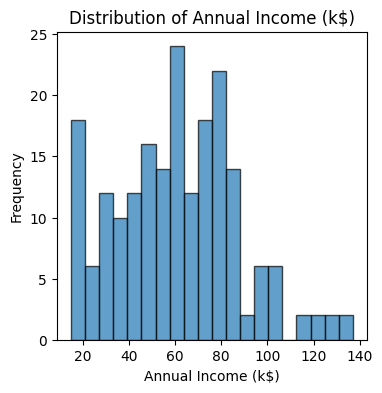

In [14]:
plot_hist("Annual Income (k$)")

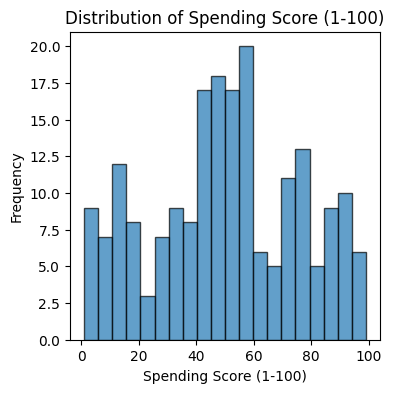

In [15]:
plot_hist("Spending Score (1-100)")

**Notes on the distributions:** The distribution for spending score looks somewhat normally distributed around 50. Annual income and age on the other hand both looks skewed a little. For gender we can see there are 112 females and 88 males so not quite even.

**Data Transformation:** In order to check for correlations we need to change Gender to a binary variable instead of the categorical Male or Female values we have. I will simply create a 'Male' column

In [16]:
# Create 'Male' column: 1 if Male, 0 otherwise
df['Male'] = df['Gender'].apply(lambda x: 1 if x == 'Male' else 0)

# Drop'Gender' column
df.drop(columns=['Gender'], inplace=True)

**Correlations:** Now we can check for correlations between the relevant features below: Age, Annual Income, Male, and Spending Score

<Axes: >

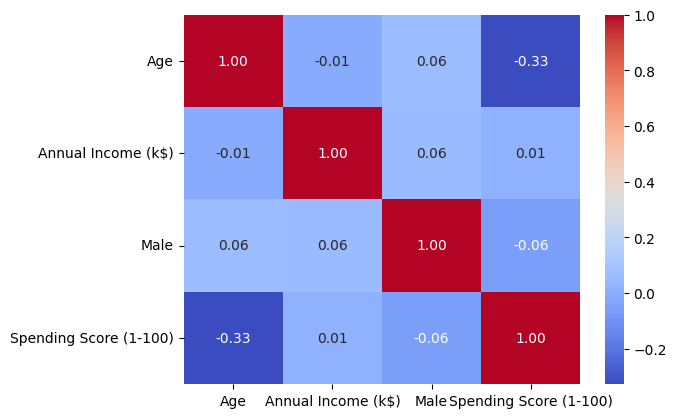

In [17]:
import seaborn as sns
corr = df[['Age', 'Annual Income (k$)', 'Male', 'Spending Score (1-100)']].corr()
sns.heatmap(corr,
            annot = True,
            fmt = '.2f',
            cmap='coolwarm',
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

We observe no significant correlations between the features outside of the relatively strong negative correlation (-0.33) between age and Spending Score. We see the next highest correlations (+/- 0.06) are between the features Male/Age, Male/Annual Income, and Male/Spending Score.

**Additional Notes on Data Transformation:** One column I may consider using a log transform on is the Annual Income feature. From prior experience I know income values in particular can be skewed right heavily (since income can include people making millions while the average still hovers far below that) and is often log transformed. However, in this case I will illustrate why this is not neccessary for this dataset.

First let's check on the skewness of the annual income using scipy. We know the range -0.5 to 0.5 indicates it is close to being normally distributed.

In [18]:
from scipy.stats import skew
skew(df['Annual Income (k$)'])

0.319423684276314

Since this is within the normal range, the skewness shouldn't warrant a log transformation. Finally, let's also check the correlation between Log Annual Income and Spending Score to again illustrate we are not losing any predictive power in not transforming it.

In [19]:
df['Log Annual Income'] = df['Annual Income (k$)'].apply(np.log)

In [20]:
corr_value = df['Spending Score (1-100)'].corr(df['Log Annual Income'])
print("Correlation between Spending Score and Log Annual Income: ", corr_value)

corr_value = df['Spending Score (1-100)'].corr(df['Annual Income (k$)'])
print("Correlation between Spending Score and Annual Income: ", corr_value)

Correlation between Spending Score and Log Annual Income:  0.008192821963346435
Correlation between Spending Score and Annual Income:  0.009902848094037612


And again we see that the log transformed Annual Income would not be useful in this case and is actually less correlated with Spending Score than the default Annual Income feature.

In [21]:
df = df.drop(columns = "Log Annual Income");

**Outliers:** Now let's check the data for any outliers. I don't suspect there will be any based on our histograms from earlier but regardless we will double check.

<Axes: ylabel='Spending Score (1-100)'>

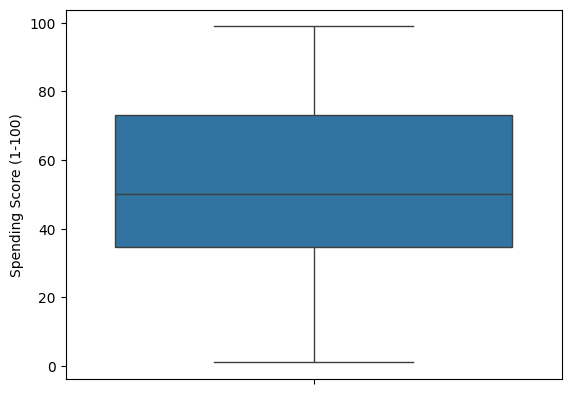

In [22]:
sns.boxplot(df['Spending Score (1-100)'])

<Axes: ylabel='Annual Income (k$)'>

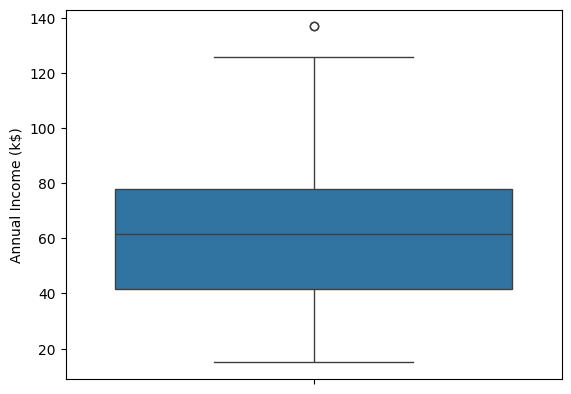

In [23]:
sns.boxplot(df['Annual Income (k$)'])

<Axes: ylabel='Age'>

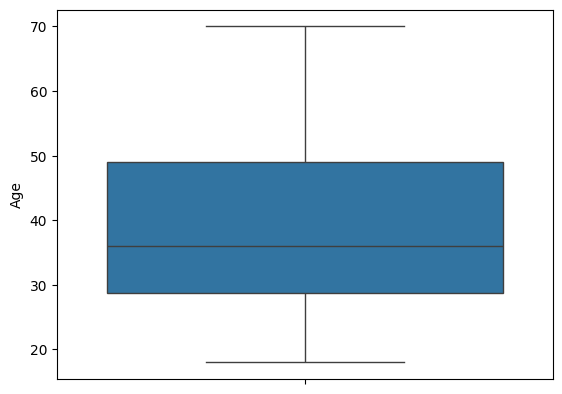

In [24]:
sns.boxplot(df['Age'])

While there is an outlier in the Annual Income column, I will not remove the outlier since it is not heavily skewing our Annual Income data. We don't have a reason to think of it as invalid and the clusters may naturally group it with other high income levels regardless.

**Factors to look out for:** I think Age will prove to be a very meaningful feature for the clustering. Logically I think it makes sense that middle-aged people are the larger spenders as they might have family to care for while older and younger people would likely spend less in a supermarket. Additionally, we saw early on it has a relatively strong correlation with spending score.

# Analysis

## Model Building

### K-Means clustering

Now let's consider the facts of our data. We do not have a lot of data (only 200 rows) and we want to determine who the highest spenders are. Logically, clustering makes sense as our initial unsupervised approach and specifically I will use **K-Means clustering** first since we have a general idea of how many clusters there will be and we can use the elbow method to find the optimal number.

However, because we are using K-Means clustering, we can't include the 'Male' feature. **K-means minimizes the sum of squared Euclidean distances** between data points and cluster centroids. But euclidean distance is not well-suited for binary variables because it assumes continuous numeric features where differences have meaningful magnitudes.

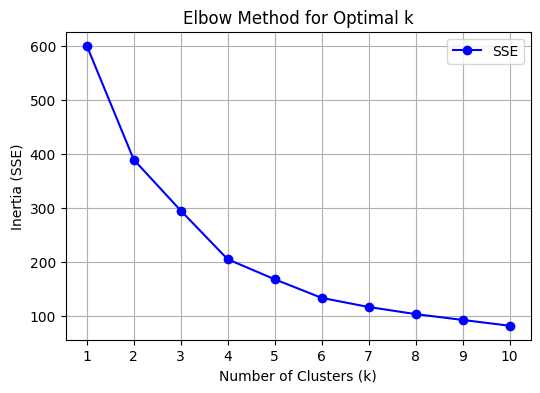

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select relevant features
X = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Compute SSE for a range of k values
wcss = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method Graph
plt.figure(figsize=(6, 4))
plt.plot(K_range, wcss, 'bo-', markersize=6, label="SSE")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (SSE)")
plt.title("Elbow Method for Optimal k")
plt.xticks(K_range)
plt.grid()
plt.legend()
plt.show()

Now that we've made the elbow plot to find the optimal k, **we should be able to look at the plot and determine where the sharpest bend is, or the elbow point.**  However, I think with this graph it's a little difficult although it looks like it may be at k=2. let's print out the inertia values first.

In [26]:
for i, inertia in enumerate(wcss):
  print('Inertia at k =', i, 'is:', inertia)

Inertia at k = 0 is: 599.9999999999999
Inertia at k = 1 is: 389.38618895643714
Inertia at k = 2 is: 295.21224615554877
Inertia at k = 3 is: 205.22514747675913
Inertia at k = 4 is: 168.2475801755683
Inertia at k = 5 is: 133.86842085478855
Inertia at k = 6 is: 117.01155455889815
Inertia at k = 7 is: 103.87329152383714
Inertia at k = 8 is: 93.0928911004172
Inertia at k = 9 is: 82.38515364526597


**Now that we have the exact inertia values, we can calculate the exact elbow point**, rather than just estimating it, **by calculating the second derivative.** Then after they are claculated we simply find the maximum of the values which represents the sharpest bend and use the corresponding k value as the optimal one in our model.

In [27]:
import numpy as np

k_values = np.arange(1, len(wcss) + 1)

# Compute second derivative
first_derivative = np.diff(wcss)
second_derivative = np.diff(first_derivative)

# Looking for the index of the maximum second derivative (elbow point)
optimal_k = k_values[1:-1][np.argmax(second_derivative)]

optimal_k

2

Now that we've mathematically determined the optimal k value for our model is 2, we can build our model and set k = 2 so our model will produce 2 clusters. We will graph the result along with our centroids with Annual Income as the x axis for one plot and Age as another so we can visualize them properly.

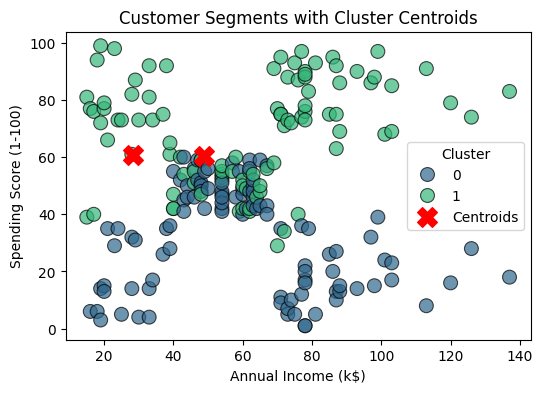

In [65]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

X = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Run K-Means with k = 2
k = 2
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Get centroids
centroids = scaler.inverse_transform(kmeans.cluster_centers_)

# Plot clusters with centroids
plt.figure(figsize=(6, 4))
sns.scatterplot(x=df['Annual Income (k$)'], y=df['Spending Score (1-100)'],
                hue=df['Cluster'], palette='viridis', s=100, alpha=0.7, edgecolor='k')
plt.scatter(centroids[:, 0], centroids[:, 1],
            c='red', marker='X', s=200, label='Centroids')

plt.title('Customer Segments with Cluster Centroids')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend(title="Cluster")
plt.show()

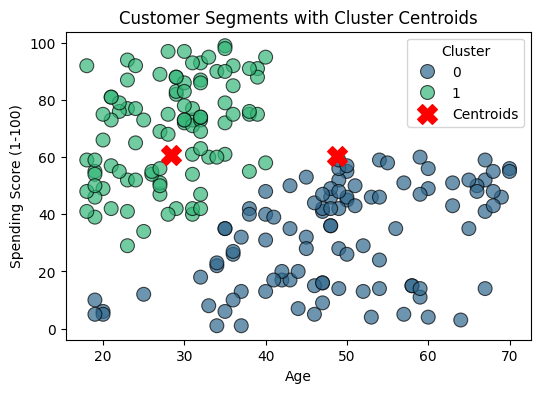

In [66]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x=df['Age'], y=df['Spending Score (1-100)'],
                hue=df['Cluster'], palette='viridis', s=100, alpha=0.7, edgecolor='k')
plt.scatter(centroids[:, 0], centroids[:, 1],
            c='red', marker='X', s=200, label='Centroids')

plt.title('Customer Segments with Cluster Centroids')
plt.xlabel('Age')
plt.ylabel('Spending Score (1-100)')
plt.legend(title="Cluster")
plt.show()

As we can see, it looks like the model did a fairly good job of clustering the data. However, I think it would be more valuable to look at a 3d representation to give a better idea of how good the clustering was done and allow us to spatially visualize the clusters in an interesting way.

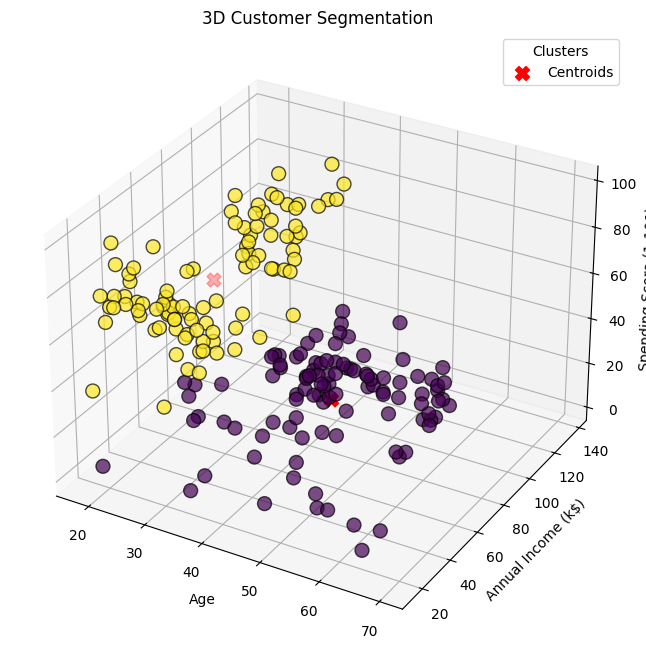

In [67]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot data points with cluster colors
scatter = ax.scatter(df['Age'], df['Annual Income (k$)'], df['Spending Score (1-100)'], c=df['Cluster'], cmap='viridis', s=100, alpha=0.7, edgecolor='k')

ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2],
           c='red', marker='X', s=100, label='Centroids')

ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
ax.set_title('3D Customer Segmentation')
plt.legend(title="Clusters")
plt.show()

Not only can we now visualize the clusters better, but this plot also tells us the clustering worked better than we probably previously thought given the other two plots. **Overall, it looks like k-means clustering did a pretty good job of separating high spenders from the low spenders.** However, let's take a look at the silhouette score and see what we get. The [Silhouette Score](https://en.wikipedia.org/wiki/Silhouette_(clustering)) can be used to calculate the quality of our clusters.

In [68]:
silhouette_avg = silhouette_score(X_scaled, df['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.33547192894004574


**We got a score of .335** which tells us we might have the right amount of clusters (otherwise we would likely get a smaller or negative score closer to -1. However, we still only got a value of .335 which from the Wikipedia link we know is a **somewhat weak clustering**, and tells us **the clusters are not too different**.

Next, let's take a close look at the two clusters and see the differences in the distributions of spending score between the two clusters.

In [69]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)
# Calculate the mean, standard deviation, and variance for the Spending Score per cluster
spending_stats = df.groupby('Cluster')['Spending Score (1-100)'].agg(['mean', 'median', 'std', 'var', 'min', 'max'])
display(spending_stats)

,mean,median,std,var,min,max
Cluster,,,,,,
0,32.184466,35.0,17.954598,322.367599,1,60
1,69.329897,73.0,17.939552,321.827534,29,99


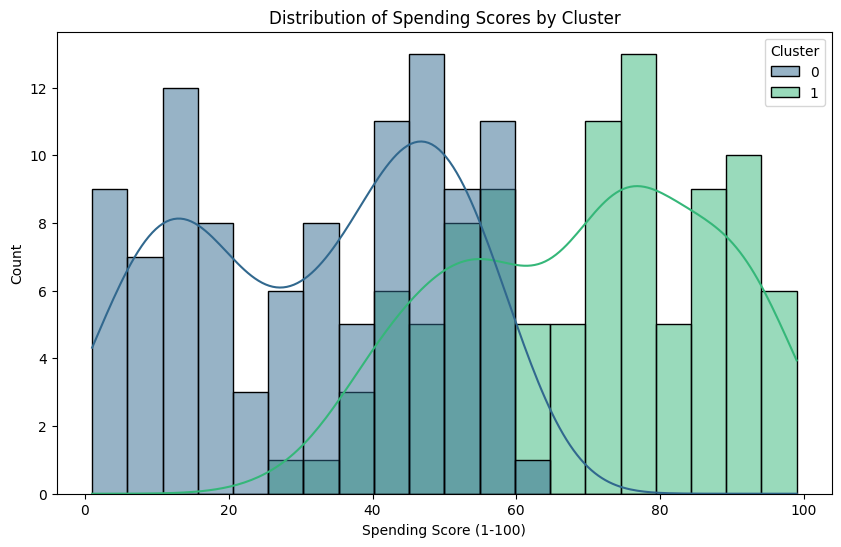

In [70]:
# Create a histogram for each cluster's Spending Score distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="Spending Score (1-100)", hue="Cluster", kde=True, bins=20, palette="viridis")

plt.title("Distribution of Spending Scores by Cluster")
plt.xlabel("Spending Score (1-100)")
plt.ylabel("Count")
plt.show()

We can see the clusters are separated about how we would expect, with essentially a high and low spending score group. We can also see they are clearly not normally distributed and we actually observe bimodal distributions for both clusters.

Next, let's look at the silhouette score for each number of clusters between 2 and 10. While we estimated k = 2 to be the best number of clusters using the elbow method, it is still only an estimate and instead we should pay attention to silhouette score if we care about well-separated clusters.

In [71]:
for i in range (2, 11):
  kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
  df['Cluster'] = kmeans.fit_predict(X_scaled)
  silhouette_avg = silhouette_score(X_scaled, df['Cluster'])
  print(f"Silhouette Score for k = {i} : {silhouette_avg}")

Silhouette Score for k = 2 : 0.33547192894004574
Silhouette Score for k = 3 : 0.357793388710272
Silhouette Score for k = 4 : 0.4039582785148566
Silhouette Score for k = 5 : 0.41664341513732767
Silhouette Score for k = 6 : 0.4284167762892593
Silhouette Score for k = 7 : 0.417231894954916
Silhouette Score for k = 8 : 0.4082067042807375
Silhouette Score for k = 9 : 0.41769250624076476
Silhouette Score for k = 10 : 0.40655411010117015


We actually find k = 6 to produce the highest silhouette score, and therefore the strongest clustering. Let's set n_clusters equal to 6 and take another look at the distribution of our clusters.

In [72]:
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Calculate the mean, standard deviation, and variance for the Spending Score per cluster
spending_stats = df.groupby('Cluster')['Spending Score (1-100)'].agg(['mean', 'median', 'std', 'var', 'min', 'max'])
display(spending_stats)

,mean,median,std,var,min,max
Cluster,,,,,,
0,49.066667,49.0,6.300794,39.700000,35,60
1,48.128205,50.0,9.966205,99.325236,10,61
2,16.969697,16.0,9.960813,99.217803,1,39
3,82.128205,83.0,9.364489,87.693657,63,97
4,77.608696,77.0,13.272457,176.158103,39,99
5,19.380952,15.0,12.555780,157.647619,3,40


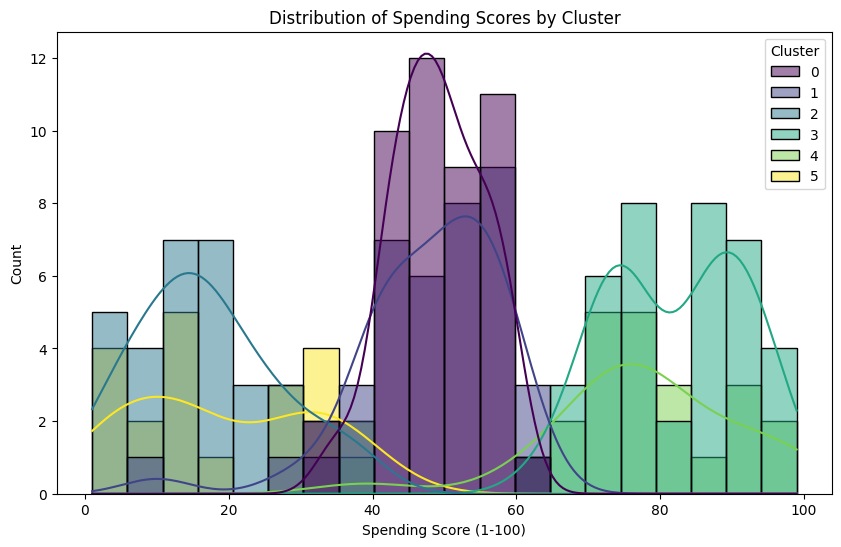

In [73]:
# Create a histogram for each cluster's Spending Score distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="Spending Score (1-100)", hue="Cluster", kde=True, bins=20, palette="viridis")

plt.title("Distribution of Spending Scores by Cluster")
plt.xlabel("Spending Score (1-100)")
plt.ylabel("Count")
plt.show()

This time we see a couple (close to) normally distributed clusters (0, 1, and 2). We also can see there are really 3 distinct groups of spenders with the new clusters. I say that since there are clearly two clusters with median spending below 20, two with the median around 50, and then two more with a median around 80.

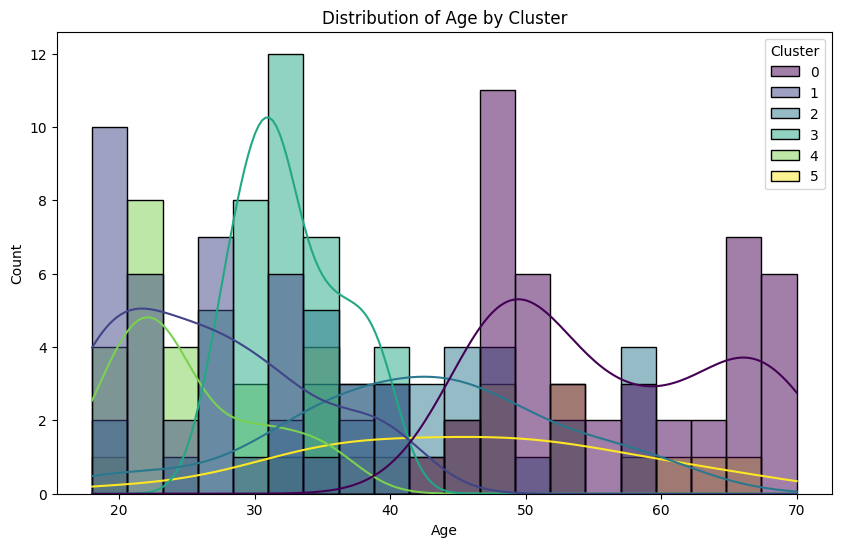

In [74]:
# Create a histogram for each cluster's Spending Score distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="Age", hue="Cluster", kde=True, bins=20, palette="viridis")

plt.title("Distribution of Age by Cluster")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

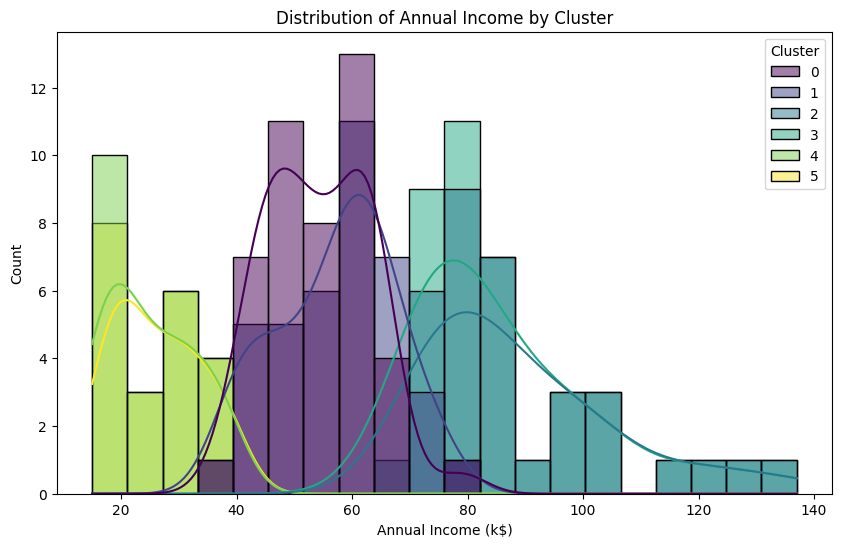

In [75]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="Annual Income (k$)", hue="Cluster", kde=True, bins=20, palette="viridis")

plt.title("Distribution of Annual Income by Cluster")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Count")
plt.show()

The annual income distribution follows a very similar trend to what we saw from the spending score. On the other hand, age is much more complex and while we see some clusters forming around specific ages, it is clear that people's ages did not influence the clusters as much as we anticipated.

### Hierarchical Clustering

Now lets briefly try implementing **hierarchical clustering** and compare the clusters to those we get for k-means clustering. One advantage of using hierarchical clustering is it's good at handling clusters with irregular shapes or sizes, unlike k-means clustering which creates a fixed number of spherical clusters.

First lets create a dendrogram to visualize the clusters. With the dendrogram we can see how closely related clusters are based on the vertical distance.

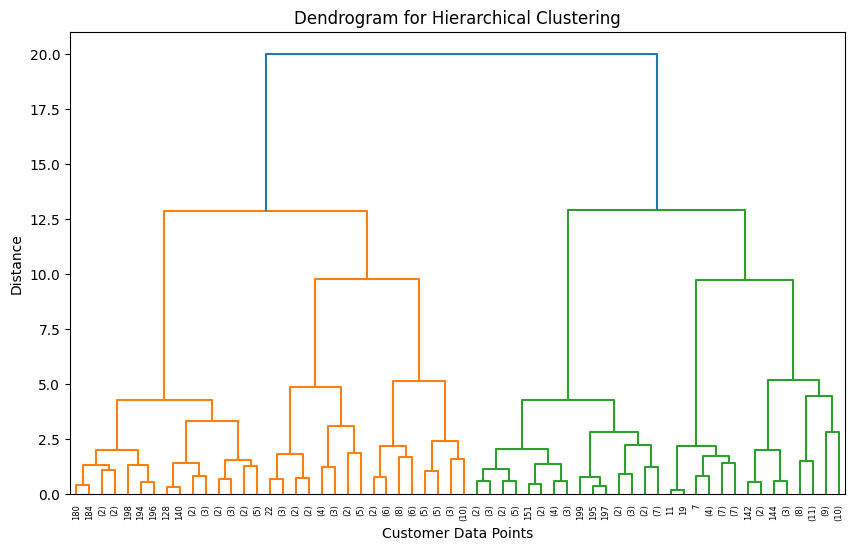

In [94]:
X = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform Hierarchical Clustering w/ Ward's Method
linkage_matrix = linkage(X_scaled, method='ward')

plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, truncate_mode='level', p=5)
plt.title("Dendrogram for Hierarchical Clustering")
plt.xlabel("Customer Data Points")
plt.ylabel("Distance")
plt.show()

The dedrogram shows us two very distinct clusters, one in orange and one in green. Additionally, we can visualize the smaller clusters that will form as we increase the number of clusters in our model. Below lets calculate the optimal number of clusters using the silhouette score.

In [101]:
for optimal_clusters in range (2, 11):
  df['Hierarchical_Cluster'] = fcluster(linkage_matrix, optimal_clusters, criterion='maxclust')
  silhouette_avg = silhouette_score(X_scaled, df['Hierarchical_Cluster'])
  print(f"Silhouette Score for k = {optimal_clusters} : {silhouette_avg}")

Silhouette Score for k = 2 : 0.31795733680759597
Silhouette Score for k = 3 : 0.32148866683112387
Silhouette Score for k = 4 : 0.3614512741691407
Silhouette Score for k = 5 : 0.39002826186267214
Silhouette Score for k = 6 : 0.4201169558789579
Silhouette Score for k = 7 : 0.3982948069934959
Silhouette Score for k = 8 : 0.36647935858620484
Silhouette Score for k = 9 : 0.3753854624760521
Silhouette Score for k = 10 : 0.3808885873908944


And after looking at the silhouette scores we see a very familiar result, which is the optimal number of clusters according to the score would be 6, and it has a score of .42 which around an identical score to the one we saw in the k-means clustering.

Instead of using the maxclust criterion, let's use distance and change the values for the parameter t. From there we can see how many clusters are returned based on the distance threshold. Also, we can see what the top silhouette score is based on the different distance thresholds.

In [102]:
for optimal_distance in range (2, 11):
  df['Hierarchical_Cluster'] = fcluster(linkage_matrix, optimal_distance, criterion='distance')
  silhouette_avg = silhouette_score(X_scaled, df['Hierarchical_Cluster'])
  print(f"Silhouette Score for distance threshold (t) = {optimal_distance} : {silhouette_avg}")

Silhouette Score for distance threshold (t) = 2 : 0.33370967676037083
Silhouette Score for distance threshold (t) = 3 : 0.35322985543969
Silhouette Score for distance threshold (t) = 4 : 0.3535716262087456
Silhouette Score for distance threshold (t) = 5 : 0.36647935858620484
Silhouette Score for distance threshold (t) = 6 : 0.4201169558789579
Silhouette Score for distance threshold (t) = 7 : 0.4201169558789579
Silhouette Score for distance threshold (t) = 8 : 0.4201169558789579
Silhouette Score for distance threshold (t) = 9 : 0.4201169558789579
Silhouette Score for distance threshold (t) = 10 : 0.3614512741691407


We see the highest scores are at t= 6, 7, 8, and 9. Let's use one of these as an example and print the number of clusters that were created using that threshold. Based on our previous scores using maxclust, we should see the optimal number of clusters is still 6.

In [105]:
best_t = 8
df['Hierarchical_Cluster'] = fcluster(linkage_matrix, best_t, criterion='distance')
# Count unique clusters
num_clusters = len(set(df['Hierarchical_Cluster']))
print(f"Optimal number of clusters: {num_clusters}")

Optimal number of clusters: 6


# Conclusion

Overall, our models performed very similarly when clustering the customer data. In both k-means clustering and hierarchical clustering we found that the optimal number of clusters is 6. In both cases we also found the highest silhouette score to be around .42 .

Our findings could be used now by the mall to cluster customers and identify characteristics about customers with high spending score, certain ages, or their income. For example, within the clusters we plotted the distributions for each feature and found how certain clusters formed around spending score ranges and annual income ranges.

It would be interesting to study this further using supervised techniques and see how well we can predict if a customer is a high or low spender based on data we have about them.